# Projet : Analyse Prédictive de la Valeur Client (CLV) avec Modélisation RFM

## Le projet a pour but de calculer la valeur à vie des clients (CLV) en combinant la segmentation RFM (Récence, Fréquence, Montant) avec des modèles prédictifs. En segmentant les clients et en prédisant leur valeur future, nous voulons recommander des stratégies adaptées pour chaque groupe, ce qui maximisera le retour sur investissement marketing.

Lien du dataset : https://archive.ics.uci.edu/dataset/352/online+retail

# Etape 1 : Nettoyage et Préparation des Données 

In [1]:
#importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as st

In [2]:
# Chargement des données
df = pd.read_excel('Online Retail.xlsx')
df.head() 

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


Les colonnes sont au bon format de type mais nous remarquons qu'il ya des valeurs manquantes dans les variables Description et CustomerID, nous traiterons cela plutard, continuons notre petite enquète sur les données.

In [4]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


Nous remarquons de l'analyse de ces statistisques qu'il ya des valeurs de Quantity et d'UnitPrice qui sont négatives, ces dernières doivent correspondre aux retours de produits ou erreurs de saisie, nous allons les gérer tout de suite.

In [5]:
#  1. Filtrons les transactions avec des valeurs négatives dans Quantity ou UnitPrice
negative_values = df[(df['Quantity'] < 0) | (df['UnitPrice'] < 0)]
print("Transactions avec valeurs négatives dans Quantity ou UnitPrice:")
negative_values[['InvoiceNo', 'Quantity', 'UnitPrice', 'CustomerID']].head()

Transactions avec valeurs négatives dans Quantity ou UnitPrice:


,InvoiceNo,Quantity,UnitPrice,CustomerID
141,C536379,-1,27.50,14527.0
154,C536383,-1,4.65,15311.0
235,C536391,-12,1.65,17548.0
236,C536391,-24,0.29,17548.0
237,C536391,-24,0.29,17548.0


In [6]:
# 2. Identifier les transactions avec InvoiceNo commençant par 'C' (indiquant des annulations, cela a été stipulé dans le dataset)
cancellations = df[df['InvoiceNo'].astype(str).str.startswith('C')]
print("\nTransactions marquées comme annulations (InvoiceNo commence par 'C'):")
cancellations[['InvoiceNo', 'Quantity', 'UnitPrice', 'CustomerID']].head()



Transactions marquées comme annulations (InvoiceNo commence par 'C'):


,InvoiceNo,Quantity,UnitPrice,CustomerID
141,C536379,-1,27.50,14527.0
154,C536383,-1,4.65,15311.0
235,C536391,-12,1.65,17548.0
236,C536391,-24,0.29,17548.0
237,C536391,-24,0.29,17548.0


In [7]:
# 3. Vérifier la proportion des transactions annulées par rapport aux transactions avec des valeurs négatives
# Combien de transactions avec valeurs négatives sont des annulations
negative_cancellations = negative_values[negative_values['InvoiceNo'].astype(str).str.startswith('C')]
print(f"\nNombre de transactions avec valeurs négatives : {len(negative_values)}")
print(f"Nombre de transactions annulées parmi celles-ci : {len(negative_cancellations)}")


Nombre de transactions avec valeurs négatives : 10626
Nombre de transactions annulées parmi celles-ci : 9288


In [8]:
# 4. Calculer le pourcentage de transactions annulées parmi celles avec des valeurs négatives
percentage_cancelled = len(negative_cancellations) / len(negative_values) * 100 if len(negative_values) > 0 else 0
print(f"\nPourcentage de transactions annulées parmi celles avec valeurs négatives : {percentage_cancelled:.2f}%")


Pourcentage de transactions annulées parmi celles avec valeurs négatives : 87.41%


L'on remarque que la grande majorité des valeurs négatives, correspondent à des transactions annulées.

Afin d'assurer la robustesse de notre analyse, nous allons travailler avec 2 dataframes, l'un comprenant les valeurs retournées et l'autre non: df_r et df_nr. Avant repartir comme cela , nous allons gérer les valeurs manquantes, en effet, les valeurs manquantes apparaissent comme vu plus haut dans les colonnes Description et CustomerID.

In [9]:
# Vérifier les nombres de valeurs manquantes dans chaque colonne
nb_na = df.isnull().sum()
nb_na[nb_na>0]

Description      1454
CustomerID     135080
dtype: int64

Nous supprimerons toutes ces valeurs car cela éliminera les transactions sans client identifiable, qui sont des transactions sans importance pour l’analyse de la CLV et de la segmentation client. De meme, l'abscence de description de produits rend difficile l'interprétation de la transaction. Cela étant dit:

In [10]:
# Supprimer les lignes avec des valeurs manquantes dans CustomerID ou Description
df = df.dropna(subset=['CustomerID', 'Description'])

# Vérification rapide après suppression des valeurs manquantes
print("Vérification des valeurs manquantes après traitement :")
print(df.isnull().sum())

Vérification des valeurs manquantes après traitement :
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [11]:
# df_r : dataframe avec les retours de produits
# df_nr : dataframe sans les retours de produits

# Créons deux copies du dataframe d'origine pour chaque version de l'analyse
df_r = df.copy()
df_nr = df[~((df['Quantity'] < 0) | (df['InvoiceNo'].astype(str).str.startswith('C')))].copy()

# Calculons le montant net (NetAmount) dans la version incluant les retours
df_r['NetAmount'] = df_r['Quantity'] * df_r['UnitPrice']

# Ajoutons une colonne pour indiquer si la transaction est une annulation (utile pour l'analyse des retours)
df_r['IsCancellation'] = df_r['InvoiceNo'].astype(str).str.startswith('C')

# Vérification rapide du nombre de transactions dans chaque version du dataframe
print(f"Nombre de transactions dans le dataset original : {len(df)}")
print(f"Nombre de transactions dans df_r (avec retours) : {len(df_r)}")
print(f"Nombre de transactions dans df_nr (sans retours) : {len(df_nr)}")

# Aperçu rapide des transactions annulées dans df_r pour confirmer l'ajout de 'IsCancellation'
print("\nTransactions annulées dans df_r (où IsCancellation est True) :")
print(df_r[df_r['IsCancellation'] == True][['InvoiceNo', 'Quantity', 'UnitPrice', 'NetAmount', 'IsCancellation']].head())


Nombre de transactions dans le dataset original : 406829
Nombre de transactions dans df_r (avec retours) : 406829
Nombre de transactions dans df_nr (sans retours) : 397924

Transactions annulées dans df_r (où IsCancellation est True) :
    InvoiceNo  Quantity  UnitPrice  NetAmount  IsCancellation
141   C536379        -1      27.50     -27.50            True
154   C536383        -1       4.65      -4.65            True
235   C536391       -12       1.65     -19.80            True
236   C536391       -24       0.29      -6.96            True
237   C536391       -24       0.29      -6.96            True


In [12]:
# Création de variables temporelles comme l’âge du client (temps écoulé depuis son premier achat), ici il sera en jours. 

# Calculer la date du premier achat de chaque client dans chaque dataframe
first_purchase_r = df_r.groupby('CustomerID')['InvoiceDate'].min().reset_index()
first_purchase_nr = df_nr.groupby('CustomerID')['InvoiceDate'].min().reset_index()

# Renommer la colonne pour indiquer qu'il s'agit de la date du premier achat
first_purchase_r.rename(columns={'InvoiceDate': 'FirstPurchaseDate'}, inplace=True)
first_purchase_nr.rename(columns={'InvoiceDate': 'FirstPurchaseDate'}, inplace=True)

# Fusionner cette information dans chaque dataframe
df_r = df_r.merge(first_purchase_r, on='CustomerID', how='left')
df_nr = df_nr.merge(first_purchase_nr, on='CustomerID', how='left')

# Calculer l'âge du client en jours au moment de chaque transaction
df_r['CustomerAge'] = (df_r['InvoiceDate'] - df_r['FirstPurchaseDate']).dt.days
df_nr['CustomerAge'] = (df_nr['InvoiceDate'] - df_nr['FirstPurchaseDate']).dt.days

# Vérification
print("Aperçu des nouvelles variables dans df_r :")
print(df_r[['CustomerID', 'InvoiceDate', 'FirstPurchaseDate', 'CustomerAge']].head())

print("\nAperçu des nouvelles variables dans df_nr :")
print(df_nr[['CustomerID', 'InvoiceDate', 'FirstPurchaseDate', 'CustomerAge']].head())


Aperçu des nouvelles variables dans df_r :
   CustomerID         InvoiceDate   FirstPurchaseDate  CustomerAge
0     17850.0 2010-12-01 08:26:00 2010-12-01 08:26:00            0
1     17850.0 2010-12-01 08:26:00 2010-12-01 08:26:00            0
2     17850.0 2010-12-01 08:26:00 2010-12-01 08:26:00            0
3     17850.0 2010-12-01 08:26:00 2010-12-01 08:26:00            0
4     17850.0 2010-12-01 08:26:00 2010-12-01 08:26:00            0

Aperçu des nouvelles variables dans df_nr :
   CustomerID         InvoiceDate   FirstPurchaseDate  CustomerAge
0     17850.0 2010-12-01 08:26:00 2010-12-01 08:26:00            0
1     17850.0 2010-12-01 08:26:00 2010-12-01 08:26:00            0
2     17850.0 2010-12-01 08:26:00 2010-12-01 08:26:00            0
3     17850.0 2010-12-01 08:26:00 2010-12-01 08:26:00            0
4     17850.0 2010-12-01 08:26:00 2010-12-01 08:26:00            0


In [13]:
''' Juste pour voir s'il ya des CustomerAge > 0 , je ne sais pas si cette variable est assez précise, 
je pense que ce serait mieux de trouver les ages en heures, mais pour le moment, continuons, on affinera au possible après '''

df_nr.loc[df_nr['CustomerAge'] > 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,FirstPurchaseDate,CustomerAge
1952,536600,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-02 08:32:00,2.55,17850.0,United Kingdom,2010-12-01 08:26:00,1
1953,536600,71053,WHITE METAL LANTERN,6,2010-12-02 08:32:00,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,1
1954,536600,82483,WOOD 2 DRAWER CABINET WHITE FINISH,4,2010-12-02 08:32:00,4.95,17850.0,United Kingdom,2010-12-01 08:26:00,1
1955,536600,82486,WOOD S/3 CABINET ANT WHITE FINISH,2,2010-12-02 08:32:00,6.95,17850.0,United Kingdom,2010-12-01 08:26:00,1
1956,536600,82482,WOODEN PICTURE FRAME WHITE FINISH,6,2010-12-02 08:32:00,2.10,17850.0,United Kingdom,2010-12-01 08:26:00,1


In [14]:
# Conversion des dates en format exploitable (durée entre deux achats, etc.), ca nous sera utile pour la RFM

# Pour chaque dataframe, trier les transactions par CustomerID et InvoiceDate
df_r = df_r.sort_values(by=['CustomerID', 'InvoiceDate'])
df_nr = df_nr.sort_values(by=['CustomerID', 'InvoiceDate'])

# Calculer la durée entre deux achats successifs pour chaque client
df_r['DaysSinceLastPurchase'] = df_r.groupby('CustomerID')['InvoiceDate'].diff().dt.days
df_nr['DaysSinceLastPurchase'] = df_nr.groupby('CustomerID')['InvoiceDate'].diff().dt.days

# Remplacer les NaN par 0 pour le premier achat de chaque client 
df_r['DaysSinceLastPurchase'].fillna(0, inplace=True)
df_nr['DaysSinceLastPurchase'].fillna(0, inplace=True)

# Vérification rapide
print("Aperçu des nouvelles variables dans df_r :")
print(df_r[['CustomerID', 'InvoiceDate', 'DaysSinceLastPurchase']].head(10))

print("\nAperçu des nouvelles variables dans df_nr :")
print(df_nr[['CustomerID', 'InvoiceDate', 'DaysSinceLastPurchase']].head(10))


Aperçu des nouvelles variables dans df_r :
       CustomerID         InvoiceDate  DaysSinceLastPurchase
38120     12346.0 2011-01-18 10:01:00                    0.0
38125     12346.0 2011-01-18 10:17:00                    0.0
10667     12347.0 2010-12-07 14:57:00                    0.0
10668     12347.0 2010-12-07 14:57:00                    0.0
10669     12347.0 2010-12-07 14:57:00                    0.0
10670     12347.0 2010-12-07 14:57:00                    0.0
10671     12347.0 2010-12-07 14:57:00                    0.0
10672     12347.0 2010-12-07 14:57:00                    0.0
10673     12347.0 2010-12-07 14:57:00                    0.0
10674     12347.0 2010-12-07 14:57:00                    0.0

Aperçu des nouvelles variables dans df_nr :
       CustomerID         InvoiceDate  DaysSinceLastPurchase
37126     12346.0 2011-01-18 10:01:00                    0.0
10516     12347.0 2010-12-07 14:57:00                    0.0
10517     12347.0 2010-12-07 14:57:00                    0

C:\Users\aubai\AppData\Local\Temp\ipykernel_71456\1629609006.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_r['DaysSinceLastPurchase'].fillna(0, inplace=True)
C:\Users\aubai\AppData\Local\Temp\ipykernel_71456\1629609006.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



# Etape 2 : Analyse RFM

## Étapes de l'Analyse RFM

    Calcul de la Récence (R) : Le nombre de jours écoulés depuis le dernier achat de chaque client par rapport à une date de référence (généralement la date la plus récente dans le dataset).
    Calcul de la Fréquence (F) : Le nombre total de transactions pour chaque client.
    Calcul du Montant (M) : Le montant total dépensé par chaque client.

In [15]:
# Concentrons nous d'abord sur df_nr
# Calculer les Scores RFM

# Vérifier si une colonne de montant total existe, sinon la créer
if 'NetAmount' not in df_nr.columns:
    df_nr['NetAmount'] = df_nr['Quantity'] * df_nr['UnitPrice']

# Calcul des scores RFM en utilisant la colonne `NetAmount`
reference_date = df_nr['InvoiceDate'].max()

# Agréger les données pour chaque client
rfm_df = df_nr.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Récence
    'InvoiceNo': 'nunique',  # Fréquence
    'NetAmount': 'sum'       # Montant total
})

# Renommer les colonnes
rfm_df.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'NetAmount': 'Monetary'}, inplace=True)

# Vérification du dataframe RFM
print("Aperçu du dataframe RFM :")
print(rfm_df.head())



Aperçu du dataframe RFM :
            Recency  Frequency  Monetary
CustomerID                              
12346.0         325          1  77183.60
12347.0           1          7   4310.00
12348.0          74          4   1797.24
12349.0          18          1   1757.55
12350.0         309          1    334.40


In [16]:
# Assignons un score de 1 à 5 pour chaque métrique (Recency, Frequency, Monetary) pour chaque client, où 5 est le score le plus favorable.

# Fonction pour calculer les scores R, F, et M par quintile
rfm_df['R_Score'] = pd.qcut(rfm_df['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)
rfm_df['F_Score'] = pd.qcut(rfm_df['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5]).astype(int)
rfm_df['M_Score'] = pd.qcut(rfm_df['Monetary'], 5, labels=[1, 2, 3, 4, 5]).astype(int)

# Calculer le score RFM global en concaténant les scores individuels
rfm_df['RFM_Score'] = rfm_df['R_Score'].astype(str) + rfm_df['F_Score'].astype(str) + rfm_df['M_Score'].astype(str)

# Vérification
print("Aperçu des scores RFM :")
print(rfm_df.head())


Aperçu des scores RFM :
            Recency  Frequency  Monetary  R_Score  F_Score  M_Score RFM_Score
CustomerID                                                                   
12346.0         325          1  77183.60        1        1        5       115
12347.0           1          7   4310.00        5        5        5       555
12348.0          74          4   1797.24        2        4        4       244
12349.0          18          1   1757.55        4        1        4       414
12350.0         309          1    334.40        1        1        2       112


Maintenant que nous avons les scores RFM, nous pouvons créer des segments en fonction de ces scores. Par exemple, nous pourrions définir des segments comme suit :

    Champions : RFM entre 555 et 455 (clients récents, fréquents, et ayant beaucoup dépensé )
    Fidèles : RFM avec un score élevé de fréquence et de montant, mais un score de récence moyen (e.g., 354, 355)
    Nouveaux : Score élevé de récence mais bas sur la fréquence et le montant
    En Dormance : Faibles scores de récence, fréquence et montant.

In [17]:
def segment_rfm(df):
    if df['RFM_Score'] == '555' or df['RFM_Score'] == '455':
        return 'Champions'
    elif df['R_Score'] >= 4 and df['F_Score'] >= 4:
        return 'Fidèles'
    elif df['R_Score'] == 5 and df['F_Score'] <= 2 and df['M_Score'] <= 2:
        return 'Nouveaux'
    elif df['R_Score'] <= 2 and df['F_Score'] <= 2:
        return 'En Dormance'
    else:
        return 'Autres'

# Appliquer la fonction de segmentation
rfm_df['Segment'] = rfm_df.apply(segment_rfm, axis=1)

# Vérification des segments
print("Aperçu des segments de clients :")
print(rfm_df[['RFM_Score', 'Segment']].head(10))


Aperçu des segments de clients :
           RFM_Score      Segment
CustomerID                       
12346.0          115  En Dormance
12347.0          555    Champions
12348.0          244       Autres
12349.0          414       Autres
12350.0          112  En Dormance
12352.0          355       Autres
12353.0          111  En Dormance
12354.0          114  En Dormance
12355.0          112  En Dormance
12356.0          435       Autres


# Analysons à présent les segments

## Cette analyse vous donnera des insights tels que :

    Les segments les plus précieux en termes de dépenses totales.
    Les segments les plus récents et ceux ayant la fréquence d'achat la plus élevée.

In [18]:
# Compter le nombre de clients et calculer le montant total par segment
segment_analysis = rfm_df.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'sum', 'count']
}).round(2)

# Renommer les colonnes pour plus de clarté
segment_analysis.columns = ['Recency_mean', 'Frequency_mean', 'Monetary_mean', 'Monetary_total', 'Customer_count']

# Trier les segments en fonction de la valeur monétaire totale
segment_analysis = segment_analysis.sort_values(by='Monetary_total', ascending=False)

print("Analyse des segments RFM :")
print(segment_analysis)


Analyse des segments RFM :
             Recency_mean  Frequency_mean  Monetary_mean  Monetary_total  \
Segment                                                                    
Champions           10.16           15.76        9492.40      4993003.21   
Autres              73.31            2.86        1183.05      2447737.50   
Fidèles             14.16            5.03        1524.83       934720.70   
En Dormance        216.90            1.10         487.71       519408.57   
Nouveaux             6.09            1.14         250.57        16537.92   

             Customer_count  
Segment                      
Champions               526  
Autres                 2069  
Fidèles                 613  
En Dormance            1065  
Nouveaux                 66  


# Visualisation des Segments pour une Meilleure Interprétation

C:\Users\aubai\AppData\Local\Temp\ipykernel_71456\998745312.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm_df, x='Segment', order=rfm_df['Segment'].value_counts().index, palette='viridis')


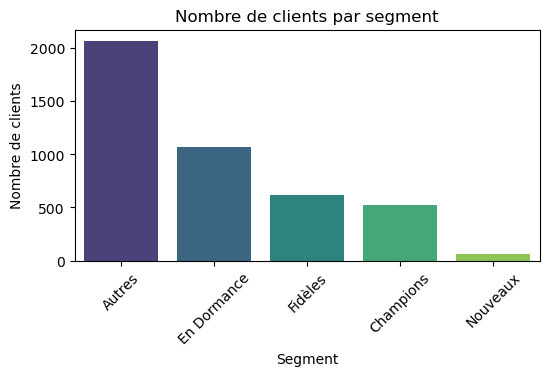

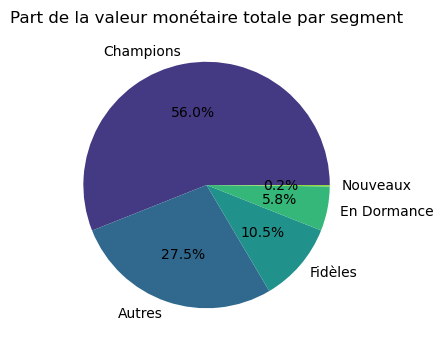

In [19]:
# Histogramme du nombre de clients par segment
plt.figure(figsize=(6, 3))
sns.countplot(data=rfm_df, x='Segment', order=rfm_df['Segment'].value_counts().index, palette='viridis')
plt.title("Nombre de clients par segment")
plt.xlabel("Segment")
plt.ylabel("Nombre de clients")
plt.xticks(rotation=45)
plt.show()

# Diagramme en Secteur pour la valeur monétaire totale par segment
plt.figure(figsize=(4, 4))
segment_analysis['Monetary_total'].plot.pie(autopct='%1.1f%%', colors=sns.color_palette("viridis", len(segment_analysis)))
plt.title("Part de la valeur monétaire totale par segment")
plt.ylabel("")  # Masquer l'étiquette de l'axe y pour plus de clarté
plt.show()


# Recommandations Stratégiques Basées sur les Segments

À partir de l'analyse des segments RFM, vous pouvons établir des stratégies spécifiques pour chaque segment :

Champions : Clients ayant des scores RFM élevés.
## Stratégie : Fidélisation par des programmes VIP, récompenses pour leur loyauté, ou avant-premières sur les produits.

Fidèles : Clients avec un score de fréquence et de montant élevés, mais un score de récence moyen.
## Stratégie : Programmes de fidélité pour les inciter à acheter plus fréquemment.

Nouveaux Clients : Clients avec un bon score de récence mais de faible fréquence et montant.
## Stratégie : Offrir des promotions pour les encourager à faire d'autres achats et explorer plus de produits.

Clients en Dormance : Clients ayant des scores faibles en récence, fréquence et montant.
## Stratégie : Relance par des offres spéciales pour tenter de réactiver leur engagement.

# Toutefois, il serait interressant pour nous de voir ce qu'il en serait en tenant compte des retours de produits afin d'ajuster notre stratégie.
## Analyse Comparative des Segments RFM entre df_nr et df_r

In [20]:
# Faisons pareil pour df_r
#  Calcul des Scores RFM pour df_r

# Date de référence pour df_r (généralement la date la plus récente)
reference_date_r = df_r['InvoiceDate'].max()

# Créer la colonne NetAmount pour df_r si elle n'existe pas
if 'NetAmount' not in df_r.columns:
    df_r['NetAmount'] = df_r['Quantity'] * df_r['UnitPrice']

# Calcul RFM pour df_r
rfm_df_r = df_r.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date_r - x.max()).days,  # Récence
    'InvoiceNo': 'nunique',  # Fréquence
    'NetAmount': 'sum'       # Montant total
})

# Renommer les colonnes pour plus de clarté
rfm_df_r.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'NetAmount': 'Monetary'}, inplace=True)

# Scoring RFM pour df_r
rfm_df_r['R_Score'] = pd.qcut(rfm_df_r['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)
rfm_df_r['F_Score'] = pd.qcut(rfm_df_r['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5]).astype(int)
rfm_df_r['M_Score'] = pd.qcut(rfm_df_r['Monetary'], 5, labels=[1, 2, 3, 4, 5]).astype(int)

# Calcul du score RFM global pour df_r
rfm_df_r['RFM_Score'] = rfm_df_r['R_Score'].astype(str) + rfm_df_r['F_Score'].astype(str) + rfm_df_r['M_Score'].astype(str)

# Déterminer les segments dans df_r comme nous l'avons fait pour df_nr
def assign_segment(rfm_score):
    if rfm_score in ["555", "554", "545", "544"]:  # Champions
        return "Champions"
    elif rfm_score in ["543", "534", "444"]:      # Fidèles
        return "Fidèles"
    elif rfm_score in ["344", "334", "333"]:      # Nouveaux Clients
        return "Nouveaux Clients"
    elif rfm_score in ["111", "112", "211"]:      # Clients en Dormance
        return "Clients en Dormance"
    else:
        return "Autres"

# Appliquer la fonction de segmentation
rfm_df_r['Segment'] = rfm_df_r['RFM_Score'].apply(assign_segment)


# Analyse Comparative des Segments RFM entre df_nr et df_r

# Analyse des segments pour df_nr
segment_analysis_nr = rfm_df.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'sum', 'count']
}).round(2)
segment_analysis_nr.columns = ['Recency_mean', 'Frequency_mean', 'Monetary_mean', 'Monetary_total', 'Customer_count']

# Analyse des segments pour df_r
segment_analysis_r = rfm_df_r.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'sum', 'count']
}).round(2)
segment_analysis_r.columns = ['Recency_mean', 'Frequency_mean', 'Monetary_mean', 'Monetary_total', 'Customer_count']

# Comparaison des deux analyses
comparison_df = segment_analysis_nr.join(segment_analysis_r, lsuffix='_nr', rsuffix='_r')
print("Comparaison des segments entre df_nr et df_r :")
print(comparison_df)


Comparaison des segments entre df_nr et df_r :
             Recency_mean_nr  Frequency_mean_nr  Monetary_mean_nr  \
Segment                                                             
Autres                 73.31               2.86           1183.05   
Champions              10.16              15.76           9492.40   
En Dormance           216.90               1.10            487.71   
Fidèles                14.16               5.03           1524.83   
Nouveaux                6.09               1.14            250.57   

             Monetary_total_nr  Customer_count_nr  Recency_mean_r  \
Segment                                                             
Autres              2447737.50               2069           94.61   
Champions           4993003.21                526            4.28   
En Dormance          519408.57               1065             NaN   
Fidèles              934720.70                613           14.00   
Nouveaux              16537.92                 66      

## Après étude comparative, des récommandations supplémentaires s'imposent:

Pour les "Champions" avec retour :

    Programmes de fidélité : Leur proposer des avantages pour les remercier de leur fidélité malgré les retours.
    Assistance dédiée : Leur offrir un support client proactif pour minimiser les retours.

Pour les "Fidèles" avec retour :

    Informations produits : S'assurer que toutes les informations (taille, description) sont précises pour réduire l'insatisfaction.
    Retours simplifiés : Offrir des politiques de retour transparentes pour éviter la perte de leur fidélité.

Pour le segment "Autres" avec retour :

    Campagnes de réengagement : Encourager ces clients à acheter plus régulièrement et réduire les retours par des recommandations produits.
    Programmes de conversion : Les guider vers des segments de plus grande fidélité (comme les "Champions") grâce à des offres adaptées.

Analyse approfondie des Nouveaux Clients :

    Un retour parmi les nouveaux clients peut indiquer un problème d’alignement entre les attentes et l'expérience réelle du produit. Améliorer la première impression de l’entreprise pourrait réduire les retours pour cette catégorie.

# 	Etape 3: Modélisation Prédictive pour la CLV
## 	Objectif : Utiliser des techniques de machine learning pour prédire la CLV de chaque segment.

In [21]:
# importons les autres bibliothèques nécessaires
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [22]:
rfm_df.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
CustomerID,,,,,,,,
12346.0,325,1,77183.60,1,1,5,115,En Dormance
12347.0,1,7,4310.00,5,5,5,555,Champions
12348.0,74,4,1797.24,2,4,4,244,Autres
12349.0,18,1,1757.55,4,1,4,414,Autres
12350.0,309,1,334.40,1,1,2,112,En Dormance


In [23]:
df_nr.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,FirstPurchaseDate,CustomerAge,DaysSinceLastPurchase,NetAmount
37126,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,2011-01-18 10:01:00,0,0.0,77183.6
10516,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12,2010-12-07 14:57:00,2.10,12347.0,Iceland,2010-12-07 14:57:00,0,0.0,25.2
10517,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2010-12-07 14:57:00,4.25,12347.0,Iceland,2010-12-07 14:57:00,0,0.0,17.0
10518,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,12,2010-12-07 14:57:00,3.25,12347.0,Iceland,2010-12-07 14:57:00,0,0.0,39.0
10519,537626,22492,MINI PAINT SET VINTAGE,36,2010-12-07 14:57:00,0.65,12347.0,Iceland,2010-12-07 14:57:00,0,0.0,23.4


In [24]:
# Calculer la CLV Historique et Préparer les Données

# Calcul de la CLV historique pour chaque client dans df_nr
clv_historique = df_nr.groupby('CustomerID')['NetAmount'].sum().rename('CLV').reset_index()

# Fusionner clv_historique avec rfm_df
# On utilise une fusion gauche pour garder tous les clients de rfm_df, même si certains n'ont pas de CLV
rfm_df = rfm_df.merge(clv_historique, on='CustomerID', how='left')

# Remplir les valeurs manquantes de CLV avec 0 (si un client n'a pas de transaction, sa CLV est 0)
rfm_df['CLV'].fillna(0, inplace=True)

# Vérification du DataFrame final avant la modélisation
print(rfm_df.head())

# Séparation des variables explicatives (features) et de la variable cible (target)
X = rfm_df[['R_Score', 'F_Score', 'M_Score', 'Recency', 'Frequency', 'Monetary']]
y = rfm_df['CLV']


   CustomerID  Recency  Frequency  Monetary  R_Score  F_Score  M_Score  \
0     12346.0      325          1  77183.60        1        1        5   
1     12347.0        1          7   4310.00        5        5        5   
2     12348.0       74          4   1797.24        2        4        4   
3     12349.0       18          1   1757.55        4        1        4   
4     12350.0      309          1    334.40        1        1        2   

  RFM_Score      Segment       CLV  
0       115  En Dormance  77183.60  
1       555    Champions   4310.00  
2       244       Autres   1797.24  
3       414       Autres   1757.55  
4       112  En Dormance    334.40  


C:\Users\aubai\AppData\Local\Temp\ipykernel_71456\534305593.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_df['CLV'].fillna(0, inplace=True)


In [25]:
# Division des données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modélisation de la CLV avec Régression Linéaire

In [26]:

# Initialiser et entraîner le modèle de régression linéaire
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred_linear = linear_model.predict(X_test)

# Évaluation des performances du modèle
rmse_linear = mean_squared_error(y_test, y_pred_linear, squared=False)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print("Performances du modèle de régression linéaire :")
print(f"RMSE : {rmse_linear}")
print(f"MAE : {mae_linear}")
print(f"R² : {r2_linear}")


Performances du modèle de régression linéaire :
RMSE : 6.500915531073702e-12
MAE : 1.7251863020588175e-12
R² : 1.0


C:\Users\aubai\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Modélisation de la CLV avec XGBoost

In [27]:
# !pip install xgboost

In [28]:
from xgboost import XGBRegressor

# Initialiser et entraîner le modèle XGBoost
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred_xgb = xgb_model.predict(X_test)

# Évaluation des performances du modèle
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\nPerformances du modèle XGBoost :")
print(f"RMSE : {rmse_xgb}")
print(f"MAE : {mae_xgb}")
print(f"R² : {r2_xgb}")


Performances du modèle XGBoost :
RMSE : 6797.388871163915
MAE : 325.72073378813434
R² : 0.4661548677391507


C:\Users\aubai\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [29]:
from sklearn.model_selection import cross_val_score

# Validation croisée pour la régression linéaire
scores = cross_val_score(linear_model, X, y, scoring='r2', cv=5)
print("Scores de validation croisée (régression linéaire) : ", scores)
print("Score moyen (R²) : ", scores.mean())


Scores de validation croisée (régression linéaire) :  [1. 1. 1. 1. 1.]
Score moyen (R²) :  1.0


## Il y'a un problème de surapprentissage avec la régression linéaire, nous n'allons pas le traiter mais plutot, l'on va se concentrer sur xgboost

In [30]:
from sklearn.model_selection import GridSearchCV

# Définir la grille de paramètres pour XGBoost
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialiser GridSearchCV avec XGBoost
grid_search = GridSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Utilisation de l'erreur quadratique moyenne comme critère
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Entraîner le modèle de recherche sur la grille
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres et le meilleur score
print("Meilleurs paramètres pour XGBoost :", grid_search.best_params_)
print("Meilleur score (RMSE) :", (-grid_search.best_score_)**0.5)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Meilleurs paramètres pour XGBoost : {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.6}
Meilleur score (RMSE) : 5092.570147995365


In [31]:

# Initialiser le modèle XGBoost avec les meilleurs paramètres trouvés
best_xgb = XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.05,       # meilleur learning_rate trouvé
    max_depth=3,              # meilleure profondeur trouvée
    n_estimators=100,         # meilleur nombre d'estimateurs
    subsample=0.6,            # meilleure fraction d'échantillonnage
    colsample_bytree=0.6,     # meilleure fraction de colonnes
    random_state=42
)

# Entraîner le modèle sur l'ensemble d'entraînement
best_xgb.fit(X_train, y_train)

# Prédire les valeurs de CLV sur l'ensemble de test
y_pred_test = best_xgb.predict(X_test)

# Calcul des métriques de performance
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)  # RMSE
mae_test = mean_absolute_error(y_test, y_pred_test)                # MAE
r2_test = r2_score(y_test, y_pred_test)                            # R²

print("\nPerformances du modèle XGBoost optimisé sur l'ensemble de test :")
print(f"RMSE : {rmse_test}")
print(f"MAE : {mae_test}")
print(f"R² : {r2_test}")



Performances du modèle XGBoost optimisé sur l'ensemble de test :
RMSE : 5242.750730214723
MAE : 515.2342159696658
R² : 0.6824226842643633


C:\Users\aubai\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Les valeurs avant l'optimisation étaient les suivantes: RMSE = 6797.388871163915, MAE = 325.72073378813434, R² = 0.4661548677391507 , on note donc une très bonne amélioration du modèle: le modèle optimise bien ses prédictions et explique bien la variabilité de la CLV.

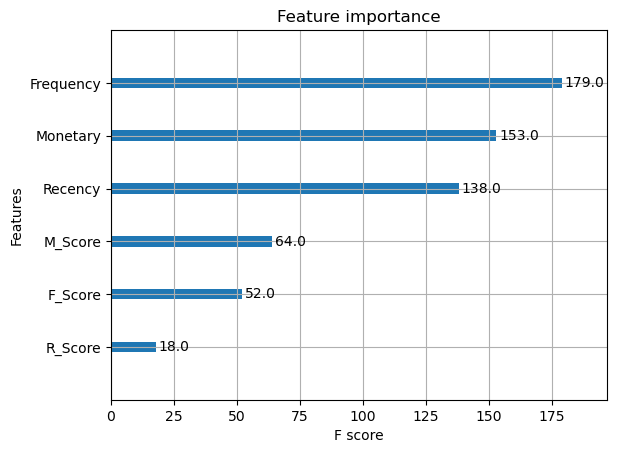

In [32]:
# Pour comprendre les facteurs qui influencent le plus la CLV et orienter les stratégies:
import xgboost as xgb

# Extraire l'importance des variables
xgb.plot_importance(best_xgb, importance_type='weight', max_num_features=10)
plt.show()


## Effectuons des prédictions de CLV

In [33]:
# Obtenir les Prédictions de CLV avec le Modèle Entraîné

# Utiliser le modèle pour prédire la CLV sur l'ensemble des clients
rfm_df['CLV_Pred'] = xgb_model.predict(X)  # X est le dataset des variables explicatives utilisé pour l’entraînement


## Segmentons les CLV prédites  

In [34]:

# Définir les quantiles pour la segmentation en fonction de la distribution de la CLV prédite
low_threshold = rfm_df['CLV_Pred'].quantile(0.33)   # 33ème percentile pour segment "Faible"
high_threshold = rfm_df['CLV_Pred'].quantile(0.66)  # 66ème percentile pour segment "Haute"

# Appliquer la segmentation basée sur les quantiles
def categorize_clv(clv_value):
    if clv_value <= low_threshold:
        return 'Faible_CLV_predite'
    elif clv_value <= high_threshold:
        return 'Moyenne_CLV_predite'
    else:
        return 'Haute_CLV_predite'

# Créer la colonne CLV_Pred_Category en appliquant la fonction de segmentation
rfm_df['CLV_Pred_Category'] = rfm_df['CLV_Pred'].apply(categorize_clv)

# Vérification de la distribution des catégories
print(rfm_df['CLV_Pred_Category'].value_counts())


CLV_Pred_Category
Haute_CLV_predite      1475
Faible_CLV_predite     1432
Moyenne_CLV_predite    1432
Name: count, dtype: int64


## Combinons les segmentation RFM et CLV

In [35]:
# Segmentation combinée des scores RFM et CLV
def segment_combined(row):
    if row['F_Score'] >= 4 and row['CLV_Pred_Category'] == 'Haute_CLV_predite':
        return 'Champions - Haute CLV Prédite'
    elif row['F_Score'] >= 4 and row['CLV_Pred_Category'] == 'Moyenne_CLV_predite':
        return 'Champions - Moyenne CLV Prédite'
    elif row['F_Score'] < 4 and row['CLV_Pred_Category'] == 'Faible_CLV_predite':
        return 'Dormants - Faible CLV Prédite'
    elif row['F_Score'] >= 2 and row['CLV_Pred_Category'] == 'Moyenne_CLV_predite':
        return 'Récents à Potentiel - Moyenne CLV Prédite'
    elif row['F_Score'] < 2 and row['CLV_Pred_Category'] == 'Haute_CLV_predite':
        return 'Nouveaux à Fort Potentiel'
    else:
        return 'Autres'

# Appliquer la segmentation combinée
rfm_df['Segment_Marketing'] = rfm_df.apply(segment_combined, axis=1)

# Vérification des catégories
print(rfm_df['Segment_Marketing'].value_counts())

Segment_Marketing
Dormants - Faible CLV Prédite                1378
Champions - Haute CLV Prédite                1234
Récents à Potentiel - Moyenne CLV Prédite     757
Autres                                        487
Champions - Moyenne CLV Prédite               448
Nouveaux à Fort Potentiel                      35
Name: count, dtype: int64


## Créeons un dictionnaire pour stocker nos stratégies par segment

In [36]:
# Dictionnaire associant chaque segment à une stratégie
strategies = {
    'Champions - Haute CLV Prédite': 'Offres VIP et programmes de fidélité exclusifs',
    'Champions - Moyenne CLV Prédite': 'Incitations ciblées pour augmenter fréquence/montant',
    'Dormants - Faible CLV Prédite': 'Campagnes de réengagement ponctuelles',
    'Récents à Potentiel - Moyenne CLV Prédite': 'Offres de bienvenue et suivi intensif',
    'Nouveaux à Fort Potentiel': 'Expérience d’accueil personnalisée et suivi VIP',
    'Autres': 'Campagnes de faible coût, surveiller évolutions'
}

# Appliquer la stratégie en fonction des segments
rfm_df['Marketing_Strategy'] = rfm_df['Segment_Marketing'].map(strategies)
print(strategies)

{'Champions - Haute CLV Prédite': 'Offres VIP et programmes de fidélité exclusifs', 'Champions - Moyenne CLV Prédite': 'Incitations ciblées pour augmenter fréquence/montant', 'Dormants - Faible CLV Prédite': 'Campagnes de réengagement ponctuelles', 'Récents à Potentiel - Moyenne CLV Prédite': 'Offres de bienvenue et suivi intensif', 'Nouveaux à Fort Potentiel': 'Expérience d’accueil personnalisée et suivi VIP', 'Autres': 'Campagnes de faible coût, surveiller évolutions'}


# Analyse Finale

## Avec ces segments, voici les grandes orientations :

 Stratégies Marketing Basées sur les Segments


    Champions - Haute CLV Prédite
        Description : Clients fidèles avec un potentiel de CLV élevé.
        Stratégie : Proposez des offres VIP, des programmes de fidélité exclusifs, et des récompenses pour la rétention. Ils sont au cœur des priorités de fidélisation.

    Champions - Moyenne CLV Prédite
        Description : Clients fidèles avec un potentiel de valeur moyen.
        Stratégie : Offrez des incitations ciblées pour augmenter la fréquence ou le montant des achats, comme des points de fidélité supplémentaires ou des offres groupées.

    Dormants - Faible CLV Prédite
        Description : Clients ayant un faible engagement et une faible CLV.
        Stratégie : Réduisez les coûts d'acquisition sur ce segment. Proposez des campagnes de réengagement ponctuelles pour mesurer leur réactivité, sans surinvestir.

    Récents à Potentiel - Moyenne CLV Prédite
        Description : Clients récents ayant une CLV moyenne. Potentiel de croissance en engagement.
        Stratégie : Favorisez l’engagement avec des offres de bienvenue, des remises sur les achats futurs, et un suivi client intensif. L’objectif est d’augmenter la fréquence d’achat.

    Nouveaux à Fort Potentiel
        Description : Nouveaux clients avec un potentiel de CLV élevé.
        Stratégie : Offrez une expérience d’accueil personnalisée. Un suivi VIP, des réductions sur les prochains achats, et des campagnes de rétention peuvent transformer ces clients en fidèles à haute valeur.

    Autres
        Description : Segment moins prioritaire pour les investissements marketing.
        Stratégie : Utilisez des campagnes de faible coût et évaluez les réponses. Limitez les offres spéciales mais surveillez les évolutions de leur comportement d'achat pour des réajustements potentiels.

In [37]:
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment,CLV,CLV_Pred,CLV_Pred_Category,Segment_Marketing,Marketing_Strategy
0,12346.0,325,1,77183.60,1,1,5,115,En Dormance,77183.60,77185.593750,Haute_CLV_predite,Nouveaux à Fort Potentiel,Expérience d’accueil personnalisée et suivi VIP
1,12347.0,1,7,4310.00,5,5,5,555,Champions,4310.00,4290.953125,Haute_CLV_predite,Champions - Haute CLV Prédite,Offres VIP et programmes de fidélité exclusifs
2,12348.0,74,4,1797.24,2,4,4,244,Autres,1797.24,1804.422974,Haute_CLV_predite,Champions - Haute CLV Prédite,Offres VIP et programmes de fidélité exclusifs
3,12349.0,18,1,1757.55,4,1,4,414,Autres,1757.55,1764.104736,Haute_CLV_predite,Nouveaux à Fort Potentiel,Expérience d’accueil personnalisée et suivi VIP
4,12350.0,309,1,334.40,1,1,2,112,En Dormance,334.40,330.742188,Faible_CLV_predite,Dormants - Faible CLV Prédite,Campagnes de réengagement ponctuelles


In [38]:
# Exporter le dataframe au format CSV
rfm_df.to_csv('ProjetMarketing1.csv', index=False, encoding='utf-8')


In [39]:
rfm_df.shape

(4339, 14)

In [40]:
rfm_df.columns

Index(['CustomerID', 'Recency', 'Frequency', 'Monetary', 'R_Score', 'F_Score',
       'M_Score', 'RFM_Score', 'Segment', 'CLV', 'CLV_Pred',
       'CLV_Pred_Category', 'Segment_Marketing', 'Marketing_Strategy'],
      dtype='object')

In [43]:
# df.loc[df['CustomerID'] == 12353, 'Column_Name'].values[0]
rfm_df.loc[rfm_df['CustomerID'] == 12353]

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment,CLV,CLV_Pred,CLV_Pred_Category,Segment_Marketing,Marketing_Strategy
6,12353.0,203,1,89.0,1,1,1,111,En Dormance,89.0,88.366043,Faible_CLV_predite,Dormants - Faible CLV Prédite,Campagnes de réengagement ponctuelles
